In [1]:
import matplotlib.pyplot as plt
import json
import numpy as np
from hkvpy import plotting
import anduryl
from pathlib import Path

%config InlineBackend.figure_format='retina'

In [2]:
cpwl = "C0"
cml = "C1"

## Import etc

In [3]:
which = '_all'

with open(f'Results/percentiles{which}.json', 'r') as f:
    percentiles_dict = json.load(f)
    
with open(f'Results/sa_scores{which}.json', 'r') as f:
    scores_dict = json.load(f)

with open(f'Results/comb_scores{which}.json', 'r') as f:
    weights_dict = json.load(f)

DMs = ['GL', 'GLopt']

In [4]:
cases = list(percentiles_dict.keys())

quantiles = {}
for key in cases:
    project = anduryl.Project()
    # file = file.replace(".mat", "")
    project.io.load_excalibur(
        Path('.').parent / "allcases2" / f"{key}.dtt", Path('.').parent / "allcases2" / f"{key}.rls"
    )
    quantiles[key] = np.array(project.assessments.quantiles[:])

## Percentile distribution

In [5]:
percentiles = {"PWL": [], "Metalog": []}

for case, subdict in percentiles_dict.items():
    for dist, subsubdict in subdict.items():
        for expid, lst in subsubdict['Chi-square'].items():
            if expid not in DMs:
                percentiles[dist].extend(lst)

In [6]:
len(percentiles['PWL'])

6864

(None,)

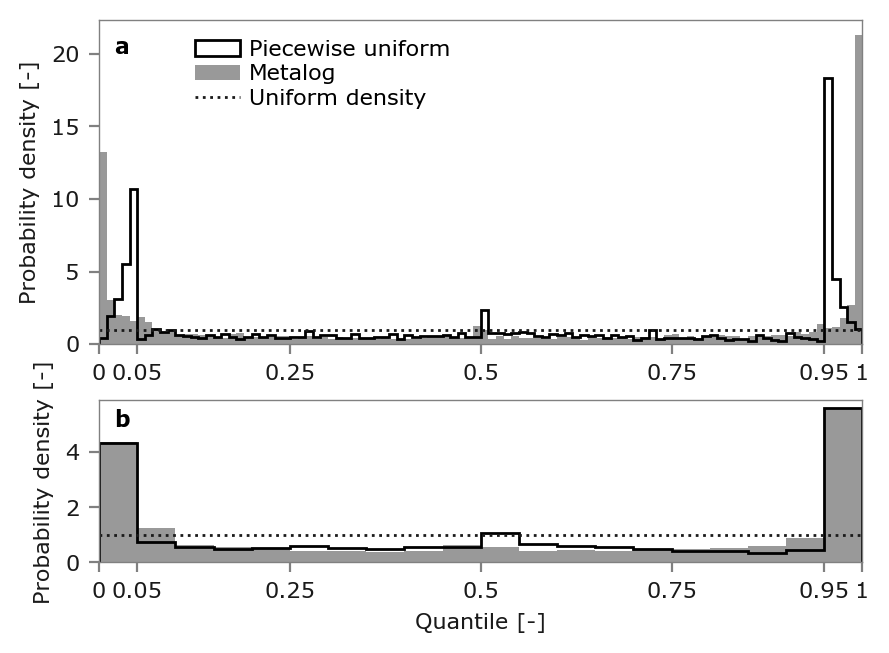

In [7]:
plotting.set_rcparams()
import matplotlib as mpl

# gs0 = mpl.gridspec.GridSpec(2, 1, height_ratios=[2, 1])
fig, axs = plt.subplots(figsize=(11/2.54, 8/2.54), constrained_layout=True, nrows=2, gridspec_kw=dict( height_ratios=[2, 1]))


bins1 = np.linspace(0, 1, 101)
bins1[5] = 0.0500001
bins1[-6] = 0.949999

bins2 = np.linspace(0, 1, 21)
bins2[1] = 0.0500001
bins2[-2] = 0.949999
for ax, bins in zip(axs, [(bins1, 100), (bins2, 20)]):
    ax.hist(percentiles["PWL"], range=(0, 1), bins=bins[0], histtype="step", density=True, label="Piecewise uniform", color='k', lw=1)
    ax.hist(percentiles["Metalog"], range=(0, 1), bins=bins[1], density=True, label="Metalog", color='.6')
    ax.set(xlim=(0, 1), ylim=ax.get_ylim())

    # ax.vlines([0.05, 0.5, 0.95], *ax.get_ylim(), color="k", ls="--")
    # ax.vlines([0.25, 0.75], *ax.get_ylim(), color="k", ls=":")
    ax.axhline(1.0, color=".1", lw=1, ls=':', label='Uniform density')
    ax.set_xticks([0.0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0])
    ax.set_xticklabels(['0', 0.05, 0.25, 0.5, 0.75, 0.95, '1'])

    if ax == axs[0]:
        ax.legend(loc='upper left', framealpha=0.0, bbox_to_anchor=(0.1, 1))

    ax.set(xlabel="Quantile [-]" if ax == axs[1] else "", ylabel="Probability density [-]")

plotting.add_panel_letters(axs, pos=(0.02, 0.95), fmt='{}')

# plt.tight_layout(pad=0.0, h_pad=1)
fig.savefig("./figures/percentile_histograms.pdf", pad_inches=0.001),

In [8]:
len(percentiles["Metalog"])

6864

In [9]:
# CHECK: Shouldn't 5, 50, 95 bins not be the same

## Compare biases to scores

In [10]:
# Calculate biases for each percentile set
biases = {}
for case, subdict in percentiles_dict.items():
    biases[case] = {}
    for dist, subsubdict in subdict.items():
        biases[case][dist] = {"mean": [], "dist": []}
        for expid, lst in subsubdict['Chi-square'].items():
            if expid not in DMs: 
                # For each expert, get the mean and average distance from mean
                biases[case][dist]["mean"].append(np.mean(lst))
                biases[case][dist]["dist"].append((np.absolute(np.array(lst) - 0.5)).mean())

sa_methods = ["Chi-square", "CRPS",  "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]

dists = ["PWL", "Metalog"]

comparison = {}
for sa_method in sa_methods:
    comparison[sa_method] = {}
    for dist in dists:
        comparison[sa_method][dist] = {"sa_scores": [], "weights": [], "means": [], "dists": []}

for case, subdict in weights_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            comparison[method][dist]["weights"].extend([lst[k] for k in lst.keys() if k not in DMs])
            comparison[method][dist]["means"].extend(biases[case][dist]["mean"])
            comparison[method][dist]["dists"].extend(biases[case][dist]["dist"])

for case, subdict in scores_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            comparison[method][dist]["sa_scores"].extend([lst[k] for k in lst.keys() if k not in DMs])

In [11]:
# nrows = 2
# ps = 2
# fig, axs = plt.subplots(
#     ncols=len(sa_methods),
#     nrows=2,
#     figsize=(ps * len(sa_methods), ps * nrows * 1.1),
#     constrained_layout=True,
# )

# partsize = 20

# for k, (sa_method, colaxs) in enumerate(zip(sa_methods, axs.T)):
#     for stat, ax in zip(["means", "dists"], colaxs):
#         size = np.array(comparison[sa_method][dists[0]]["sa_scores"]).size
#         for i in range(0, size, partsize):
#             for marker, lw, dist, color in zip(["o", "x"], [0.0, 0.5], dists, [cml, cpwl]):
#                 weights = np.array(comparison[sa_method][dist]["sa_scores"])[i:min(size, i+partsize)]
#                 ax.scatter(
#                     weights,
#                     comparison[sa_method][dist][stat][i:min(size, i+partsize)],
#                     s=4 + weights * 5,
#                     alpha=0.5,
#                     lw=lw * (0.75 + weights * 1.5),
#                     marker=marker,
#                     rasterized=True,
#                     color=color
#                 )

#     colaxs[0].set(
#         # xlim=(-0.01, 1.01),
#         ylim=(-0.01, 1.01),
#         xticks=[0, 1],
#         yticks=[0, 1],
#         aspect=1,
#         ylabel="Mean percentile" if k == 0 else "",
#     )
#     colaxs[1].set(
#         xlim=(-0.01, 1.01),
#         ylim=(-0.01, 0.51),
#         xticks=[0, 1],
#         yticks=[0, 0.5],
#         yticklabels=[0, "½"],
#         aspect=2,
#         xlabel="SA",
#         ylabel="Mean percentile distance" if k == 0 else "",
#     )

#     colaxs[0].axhline(0.5, color="grey", lw=0.75)
#     colaxs[1].axhline(0.25, color="grey", lw=0.75)

#     colaxs[0].text(0.5, 0.1, s="Left skewed", ha="center", va="top", color="grey", style="italic")
#     colaxs[0].text(0.5, 0.9, s="Right skewed", ha="center", va="bottom", color="grey", style="italic")

#     colaxs[1].text(0.5, 0.05, s="Underconfident", ha="center", va="top", color="grey", style="italic")
#     colaxs[1].text(0.5, 0.45, s="Overconfident", ha="center", va="bottom", color="grey", style="italic")

#     colaxs[0].set_title(sa_method)

# plt.tight_layout(h_pad=-0.1)

# fig.savefig("./figures/bias_scatters.pdf", dpi=220, bbox_inches="tight", pad_inches=0.001)

## CRPS focus

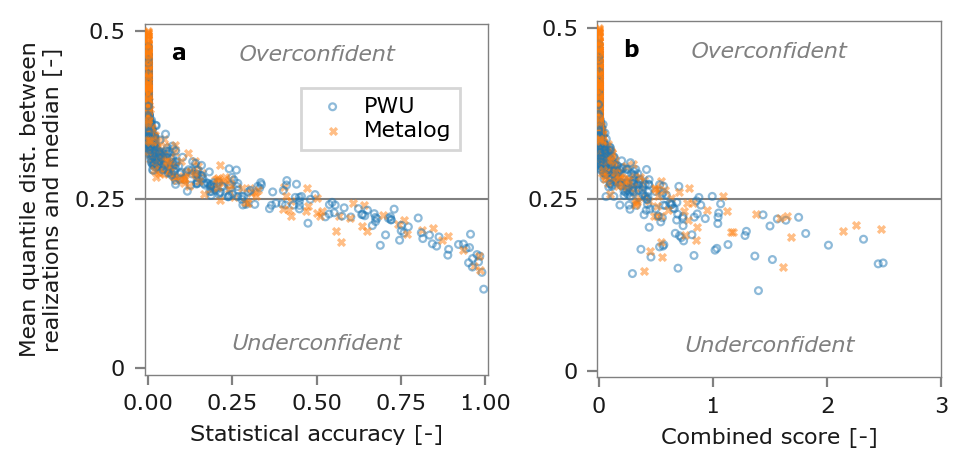

In [12]:
fig, axs = plt.subplots(
    ncols=2,
    nrows=1,
    figsize=(12/2.54, 7/2.54),
    constrained_layout=True,
)

partsize = 20

sa_method = 'CRPS'
stat = 'dists'

size = np.array(comparison[sa_method][dists[0]]["sa_scores"]).size
for i in range(0, size, partsize):
    for marker, lw, dist, color, fc in zip(["o", "x"], [0.4, 0.6], ['PWL', 'Metalog'], [cpwl, cml], ['none', cml]):
        weights = np.array(comparison[sa_method][dist]["sa_scores"])[i:min(size, i+partsize)]
        axs[0].scatter(
                    weights,
                    comparison[sa_method][dist][stat][i:min(size, i+partsize)],
                    s=6,#4 + weights * 5,
                    alpha=0.5,
                    lw=lw * 2,#(0.75 + weights * 1.5),
                    marker=marker,
                    rasterized=True,
                    color={'Metalog': cml, 'PWL': cpwl}[dist],
                    label=dist.replace('PWL', 'PWU') if i == 0 else None,
                    zorder=i + lw,
                    facecolor=fc
                )

size = np.array(comparison[sa_method][dists[0]]["weights"]).size
for i in range(0, size, partsize):
    for marker, lw, dist, color, fc in zip(["o", "x"], [0.4, 0.6], ['PWL', 'Metalog'], [cpwl, cml], ['none', cml]):
        sizes = np.array(comparison[sa_method][dist]["sa_scores"])[i:min(size, i+partsize)]
        weights = np.array(comparison[sa_method][dist]["weights"])[i:min(size, i+partsize)]
        axs[1].scatter(
                    weights,
                    comparison[sa_method][dist][stat][i:min(size, i+partsize)],
                    s=6,#4 + weights * 5,
                    alpha=0.5,
                    lw=lw * 2,#(0.75 + weights * 1.5),
                    marker=marker,
                    rasterized=True,
                    color={'Metalog': cml, 'PWL': cpwl}[dist],
                    label=dist.replace('PWL', 'PWU') if i == 0 else None,
                    zorder=i + lw,
                    facecolor=fc
                )

for i, ax in enumerate(axs):
    ax.set(
        xlim=(-0.01, 1.01 if i == 0 else 3),
        ylim=(-0.01, 0.51),
        # xticks=[0, 1],
        yticks=[0, 0.25, 0.5],
        yticklabels=[0, 0.25, 0.5],
        aspect=2 if i ==0 else 6,
        xlabel="Statistical accuracy [-]" if i == 0 else 'Combined score [-]',
        ylabel="Mean quantile dist. between\nrealizations and median [-]" if i == 0 else "",
    )
    
    ax.axhline(0.25, color="grey", lw=0.75)
    
    ax.text(np.mean(ax.get_xlim()), 0.05, s="Underconfident", ha="center", va="top", color="grey", style="italic")
    ax.text(np.mean(ax.get_xlim()), 0.45, s="Overconfident", ha="center", va="bottom", color="grey", style="italic")

axs[0].legend(loc='upper right', bbox_to_anchor=(0.95, 0.85))

plotting.add_panel_letters(axs, pos=(0.12, 0.95), ha='right', fmt='{}')

fig.savefig("./figures/bias_scatters_CRPS.pdf", dpi=220, bbox_inches="tight", pad_inches=0.001)

## Bias scatters 2

In [13]:
# for case, subdict in percentiles_dict.items():
#     subsubdict1 = subdict['PWL']
#     subsubdict2 = subdict['Metalog']
    
#     for expid, lst1 in subsubdict1.items():
#         lst1 = np.array(lst1)
#         lst2 = np.array(subsubdict2[expid])

#         if calc_over_under(lst1) != calc_over_under(lst2):
#             raise ValueError(case, expid, lst1, lst2)

In [14]:
def calc_skewed(lst):
    skewed = abs((lst < 0.5+1e-5).sum() / len(lst)) - 0.5
    return skewed

def calc_over_under(lst, eq):
    tail_count = ((lst <= (eq+1e-5)) | (lst >= (1-eq-1e-5))).sum()
    tail_expected = len(lst) * (eq * 2)
    over_under = tail_count / tail_expected
    return over_under


neutral_skewness = 0.5
neutral_kurtosis = 1
   

# Calculate biases for each percentile set
biases = {}
for case, subdict in percentiles_dict.items():
    biases[case] = {}
    for dist, subsubdict in subdict.items():
        biases[case][dist] = {"mean": [], "dist": []}
        for expid, lst in subsubdict['Chi-square'].items():
            if expid not in DMs:
                lst = np.array(lst)
                # For each expert, get the mean and average distance from mean
                skewed = calc_skewed(lst)
                over_under = calc_over_under(lst, eq=quantiles[case][0])
                # print(over_under)
    
                biases[case][dist]["mean"].append(skewed)
                biases[case][dist]["dist"].append(over_under)
                
                # if dist == 'Metalog':
                    # print(biases[case]['PWL']["dist"][-1], over_under)

In [15]:
sa_methods = ["Chi-square", "CRPS",  "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]

dists = ["PWL", "Metalog"]

comparison = {}
for sa_method in sa_methods:
    comparison[sa_method] = {}
    for dist in dists:
        comparison[sa_method][dist] = {"sa_scores": [], "weights": [], "means": [], "dists": []}

for case, subdict in weights_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            
            comparison[method][dist]["weights"].extend([lst[k] for k in lst.keys() if k not in DMs])
            comparison[method][dist]["means"].extend(biases[case][dist]["mean"])
            comparison[method][dist]["dists"].extend(biases[case][dist]["dist"])
            
for case, subdict in scores_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            comparison[method][dist]["sa_scores"].extend([lst[k] for k in lst.keys() if k not in DMs])
            

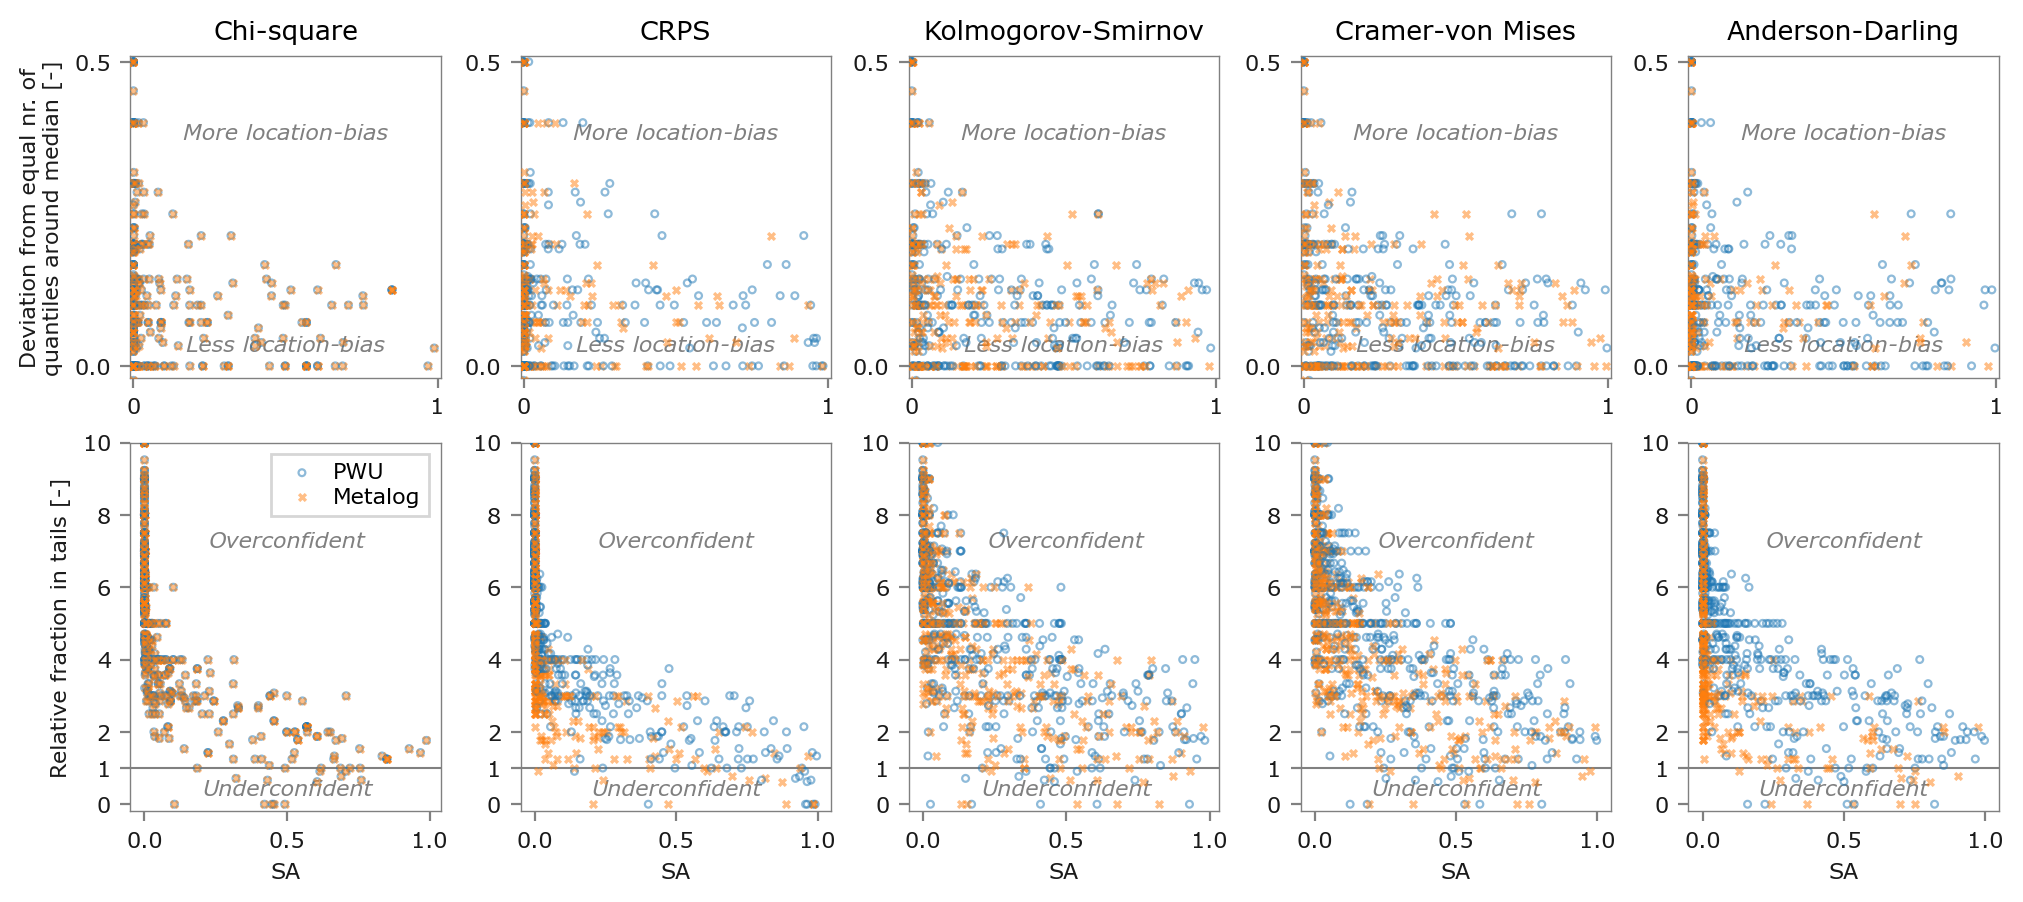

In [16]:
nrows = 2
ps = 2
fig, axs = plt.subplots(
    ncols=len(sa_methods),
    nrows=2,
    figsize=(ps * len(sa_methods), ps * nrows * 1.1),
    constrained_layout=True,
)

partsize = 20

for k, (sa_method, colaxs) in enumerate(zip(sa_methods, axs.T)):
    for stat, ax in zip(["means", "dists"], colaxs):
        size = np.array(comparison[sa_method][dists[0]]["sa_scores"]).size
        for i in range(0, size, partsize):
            for marker, lw, dist, color, fc in zip(["o", "x"], [0.4, 0.6], ['PWL', 'Metalog'], [cpwl, cml], ['none', cml]):
                weights = np.array(comparison[sa_method][dist]["sa_scores"])[i:min(size, i+partsize)]
                ax.scatter(
                    weights,
                    comparison[sa_method][dist][stat][i:min(size, i+partsize)],
                    s=6,#4 + weights * 5,
                    alpha=0.5,
                    lw=lw * 2,#(0.75 + weights * 1.5),
                    marker=marker,
                    rasterized=True,
                    color={'Metalog': cml, 'PWL': cpwl}[dist],
                    label=dist.replace('PWL', 'PWU') if i == 0 else None,
                    zorder=i + lw,
                    facecolor=fc,
                )
                
    colaxs[0].set(
        xlim=(-0.01, 1.01),
        ylim=(-0.02, 0.51),
        xticks=[0, 1],
        yticks=[0, 0.5],
        aspect=2,
        ylabel="Deviation from equal nr. of\nquantiles around median [-]" if k == 0 else "",
    )
    colaxs[1].set(
        # xlim=(-0.01, 1.01),
        ylim=(-0.2, 10),
        # xticks=[0, 1],
        yticks=[0, 1, 2, 4, 6, 8, 10],
        # yticklabels=[0, "½"],
        # aspect=2,
        # yscale='log',
        xlabel="SA",
        ylabel="Relative fraction in tails [-]" if k == 0 else "",
    )

    # colaxs[0].axhline(neutral_skewness, color="grey", lw=0.75)
    colaxs[1].axhline(neutral_kurtosis, color="grey", lw=0.75)

    colaxs[0].text(0.5, 0.4, s="More location-bias", ha="center", va="top", color="grey", style="italic")
    colaxs[0].text(0.5, 0.05, s="Less location-bias", ha="center", va="top", color="grey", style="italic")
    # colaxs[0].text(0.5, 0.9, s="Overestimating", ha="center", va="bottom", color="grey", style="italic")

    if k == 0:
        colaxs[1].legend()
    colaxs[1].text(0.5, 0.7, s="Underconfident", ha="center", va="top", color="grey", style="italic")
    colaxs[1].text(0.5, 7, s="Overconfident", ha="center", va="bottom", color="grey", style="italic")

    colaxs[0].set_title(sa_method)

# plt.tight_layout(h_pad=-0.1)

fig.savefig("./figures/bias_scatters_v2.pdf", dpi=220, bbox_inches="tight", pad_inches=0.001)

## Bias scatters 3

In [17]:
from scipy.stats import skew, kurtosis

def calc_skewed(lst):
    skewed = skew(lst)
    return skewed

def calc_over_under(lst):
    over_under = kurtosis(lst)
    return over_under

neutral_skewness = 0
neutral_kurtosis = -6/5.


# Calculate biases for each percentile set
biases = {}
for case, subdict in percentiles_dict.items():
    biases[case] = {}
    for dist, subsubdict in subdict.items():
        biases[case][dist] = {"mean": [], "dist": []}
        for expid, lst in subsubdict['Chi-square'].items():
            if expid not in DMs:
                lst = np.array(lst)
                # For each expert, get the mean and average distance from mean
                skewed = calc_skewed(lst)
                over_under = calc_over_under(lst)
                # print(over_under)
                biases[case][dist]["mean"].append(skewed)
                biases[case][dist]["dist"].append(over_under)


sa_methods = ["Chi-square", "CRPS",  "Kolmogorov-Smirnov", "Cramer-von Mises", "Anderson-Darling"]

dists = ["PWL", "Metalog"]

comparison = {}
for sa_method in sa_methods:
    comparison[sa_method] = {}
    for dist in dists:
        comparison[sa_method][dist] = {"sa_scores": [], "weights": [], "means": [], "dists": []}

for case, subdict in weights_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            comparison[method][dist]["weights"].extend([lst[k] for k in lst.keys() if k not in DMs])
            comparison[method][dist]["means"].extend(biases[case][dist]["mean"])
            comparison[method][dist]["dists"].extend(biases[case][dist]["dist"])

for case, subdict in scores_dict.items():
    for dist, subsubdict in subdict.items():
        for method, lst in subsubdict.items():
            comparison[method][dist]["sa_scores"].extend([lst[k] for k in lst.keys() if k not in DMs])

C:\Users\gwfrongen\AppData\Local\Temp\ipykernel_15664\1519940711.py:60: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout(h_pad=-0.1)


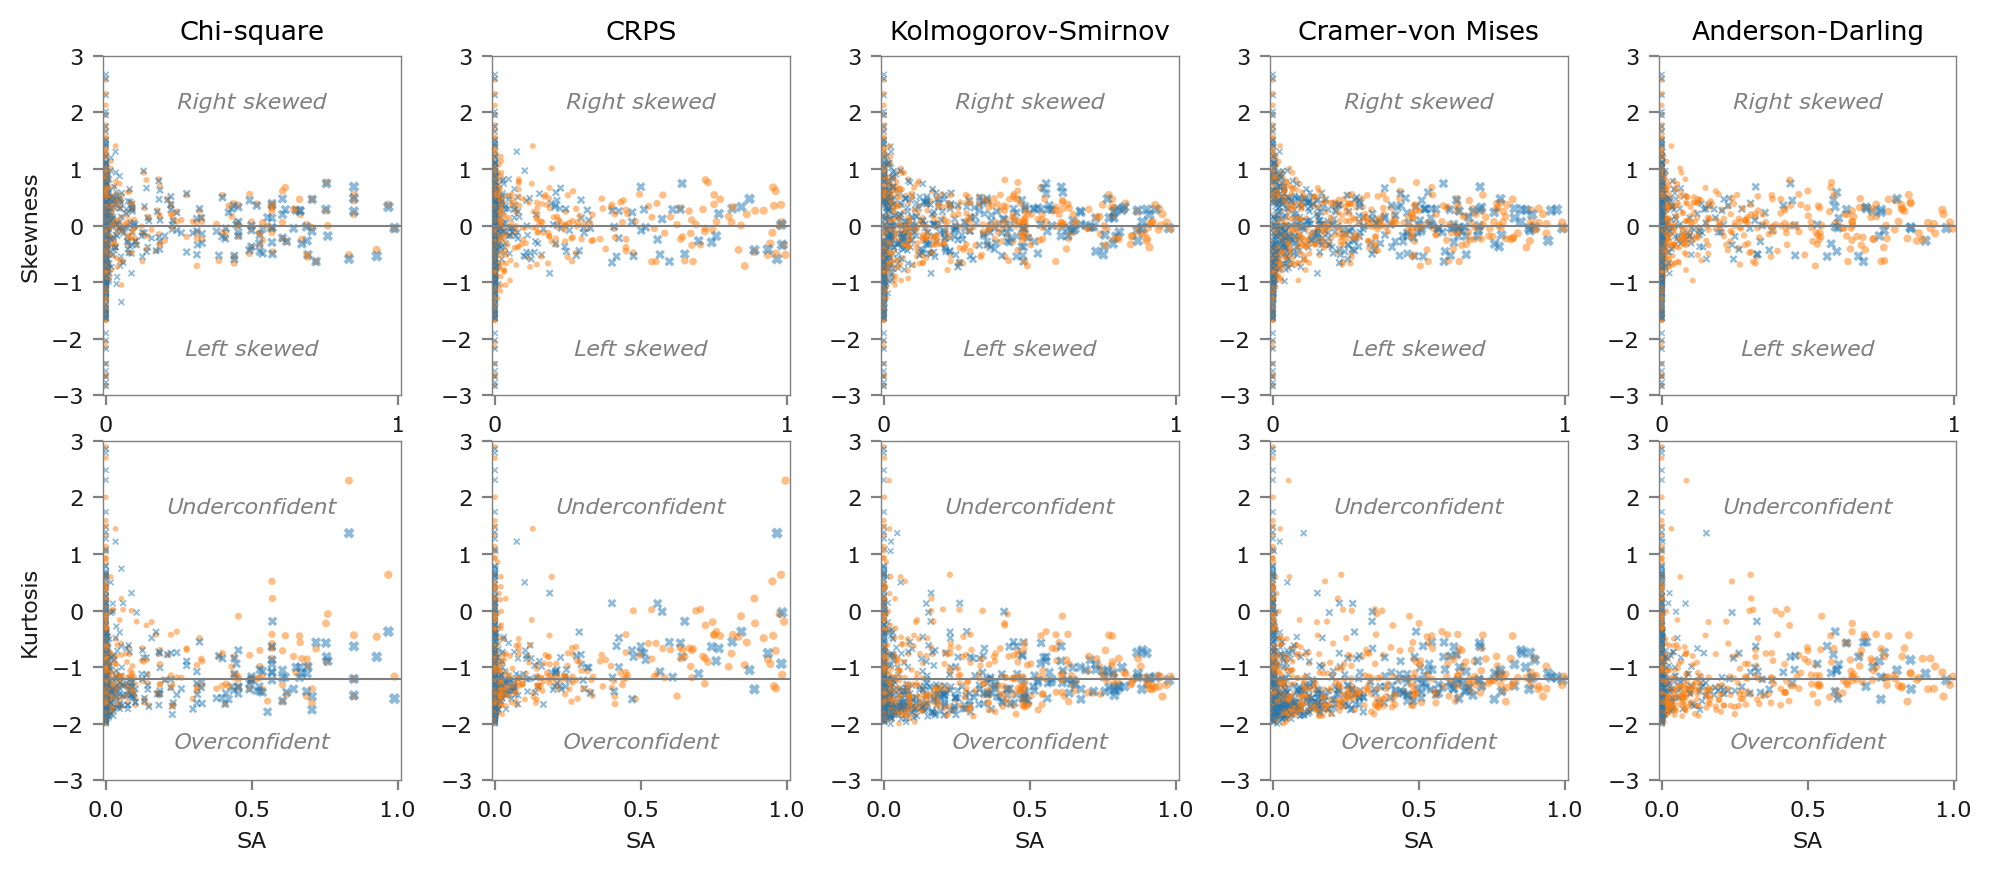

In [18]:
nrows = 2
ps = 2
fig, axs = plt.subplots(
    ncols=len(sa_methods),
    nrows=2,
    figsize=(ps * len(sa_methods), ps * nrows * 1.1),
    constrained_layout=True,
)

partsize = 20

for k, (sa_method, colaxs) in enumerate(zip(sa_methods, axs.T)):
    for stat, ax in zip(["means", "dists"], colaxs):
        size = np.array(comparison[sa_method][dists[0]]["sa_scores"]).size
        for i in range(0, size, partsize):
            for marker, lw, dist, color in zip(["o", "x"], [0.0, .75], dists, [cml, cpwl]):
                weights = np.array(comparison[sa_method][dist]["sa_scores"])[i:min(size, i+partsize)]
                ax.scatter(
                    weights,
                    comparison[sa_method][dist][stat][i:min(size, i+partsize)],
                    s=4 + weights * 5,
                    alpha=0.5,
                    lw=lw * (0.75 + weights * 1.5),
                    marker=marker,
                    rasterized=True,
                    color=color
                )

    colaxs[0].set(
        xlim=(-0.01, 1.01),
        ylim=(-3, 3),
        xticks=[0, 1],
        # yticks=[0, 1],
        # aspect=1,
        ylabel="Skewness" if k == 0 else "",
    )
    colaxs[1].set(
        xlim=(-0.01, 1.01),
        ylim=(-3, 3),
        # xticks=[0, 1],
        # yticks=[0, 0.5],
        # yticklabels=[0, "½"],
        # aspect=2,
        # yscale='log',
        xlabel="SA",
        ylabel="Kurtosis" if k == 0 else "",
    )

    colaxs[0].axhline(neutral_skewness, color="grey", lw=0.75)
    colaxs[1].axhline(neutral_kurtosis, color="grey", lw=0.75)

    colaxs[0].text(0.5, -2, s="Left skewed", ha="center", va="top", color="grey", style="italic")
    colaxs[0].text(0.5, 2, s="Right skewed", ha="center", va="bottom", color="grey", style="italic")

    colaxs[1].text(0.5, 2, s="Underconfident", ha="center", va="top", color="grey", style="italic")
    colaxs[1].text(0.5, -2.5, s="Overconfident", ha="center", va="bottom", color="grey", style="italic")

    colaxs[0].set_title(sa_method)

plt.tight_layout(h_pad=-0.1)

fig.savefig("./figures/bias_scatters_v3.pdf", dpi=220, bbox_inches="tight", pad_inches=0.001)

## Scores per method

In [19]:
import pandas as pd

dfs = {}

# fig, axs = plt.subplots(ncols=5, figsize=(10, 4), constrained_layout=True, nrows=2)
for j, dist in enumerate(['PWL', 'Metalog']):
    df = pd.concat({case: pd.DataFrame(scores_dict[case][dist]) for case in scores_dict.keys()})

    dfs[dist] = df.drop(DMs, level=1, axis=0)#.drop('Kolmogorov-Smirnov', axis=1)
    
    # for i, (name, col) in enumerate(df.items()):
    #     axs[j, i].hist(col, bins=20, range=(0, 1), alpha=0.7)
    #     axs[j, i].hist(col, bins=20, range=(0, 1), cumulative=True, alpha=0.3, zorder=-10)
    #     axs[j, i].set(title=name, ylim=(0, 540), xlim=(0, 1))


In [20]:
from scipy.stats import spearmanr
import seaborn as sns

In [21]:
variables = [
    "Chi-square",
    "CRPS",
    "Kolmogorov-Smirnov",
    "Cramer-von Mises",
    "Anderson-Darling",
]

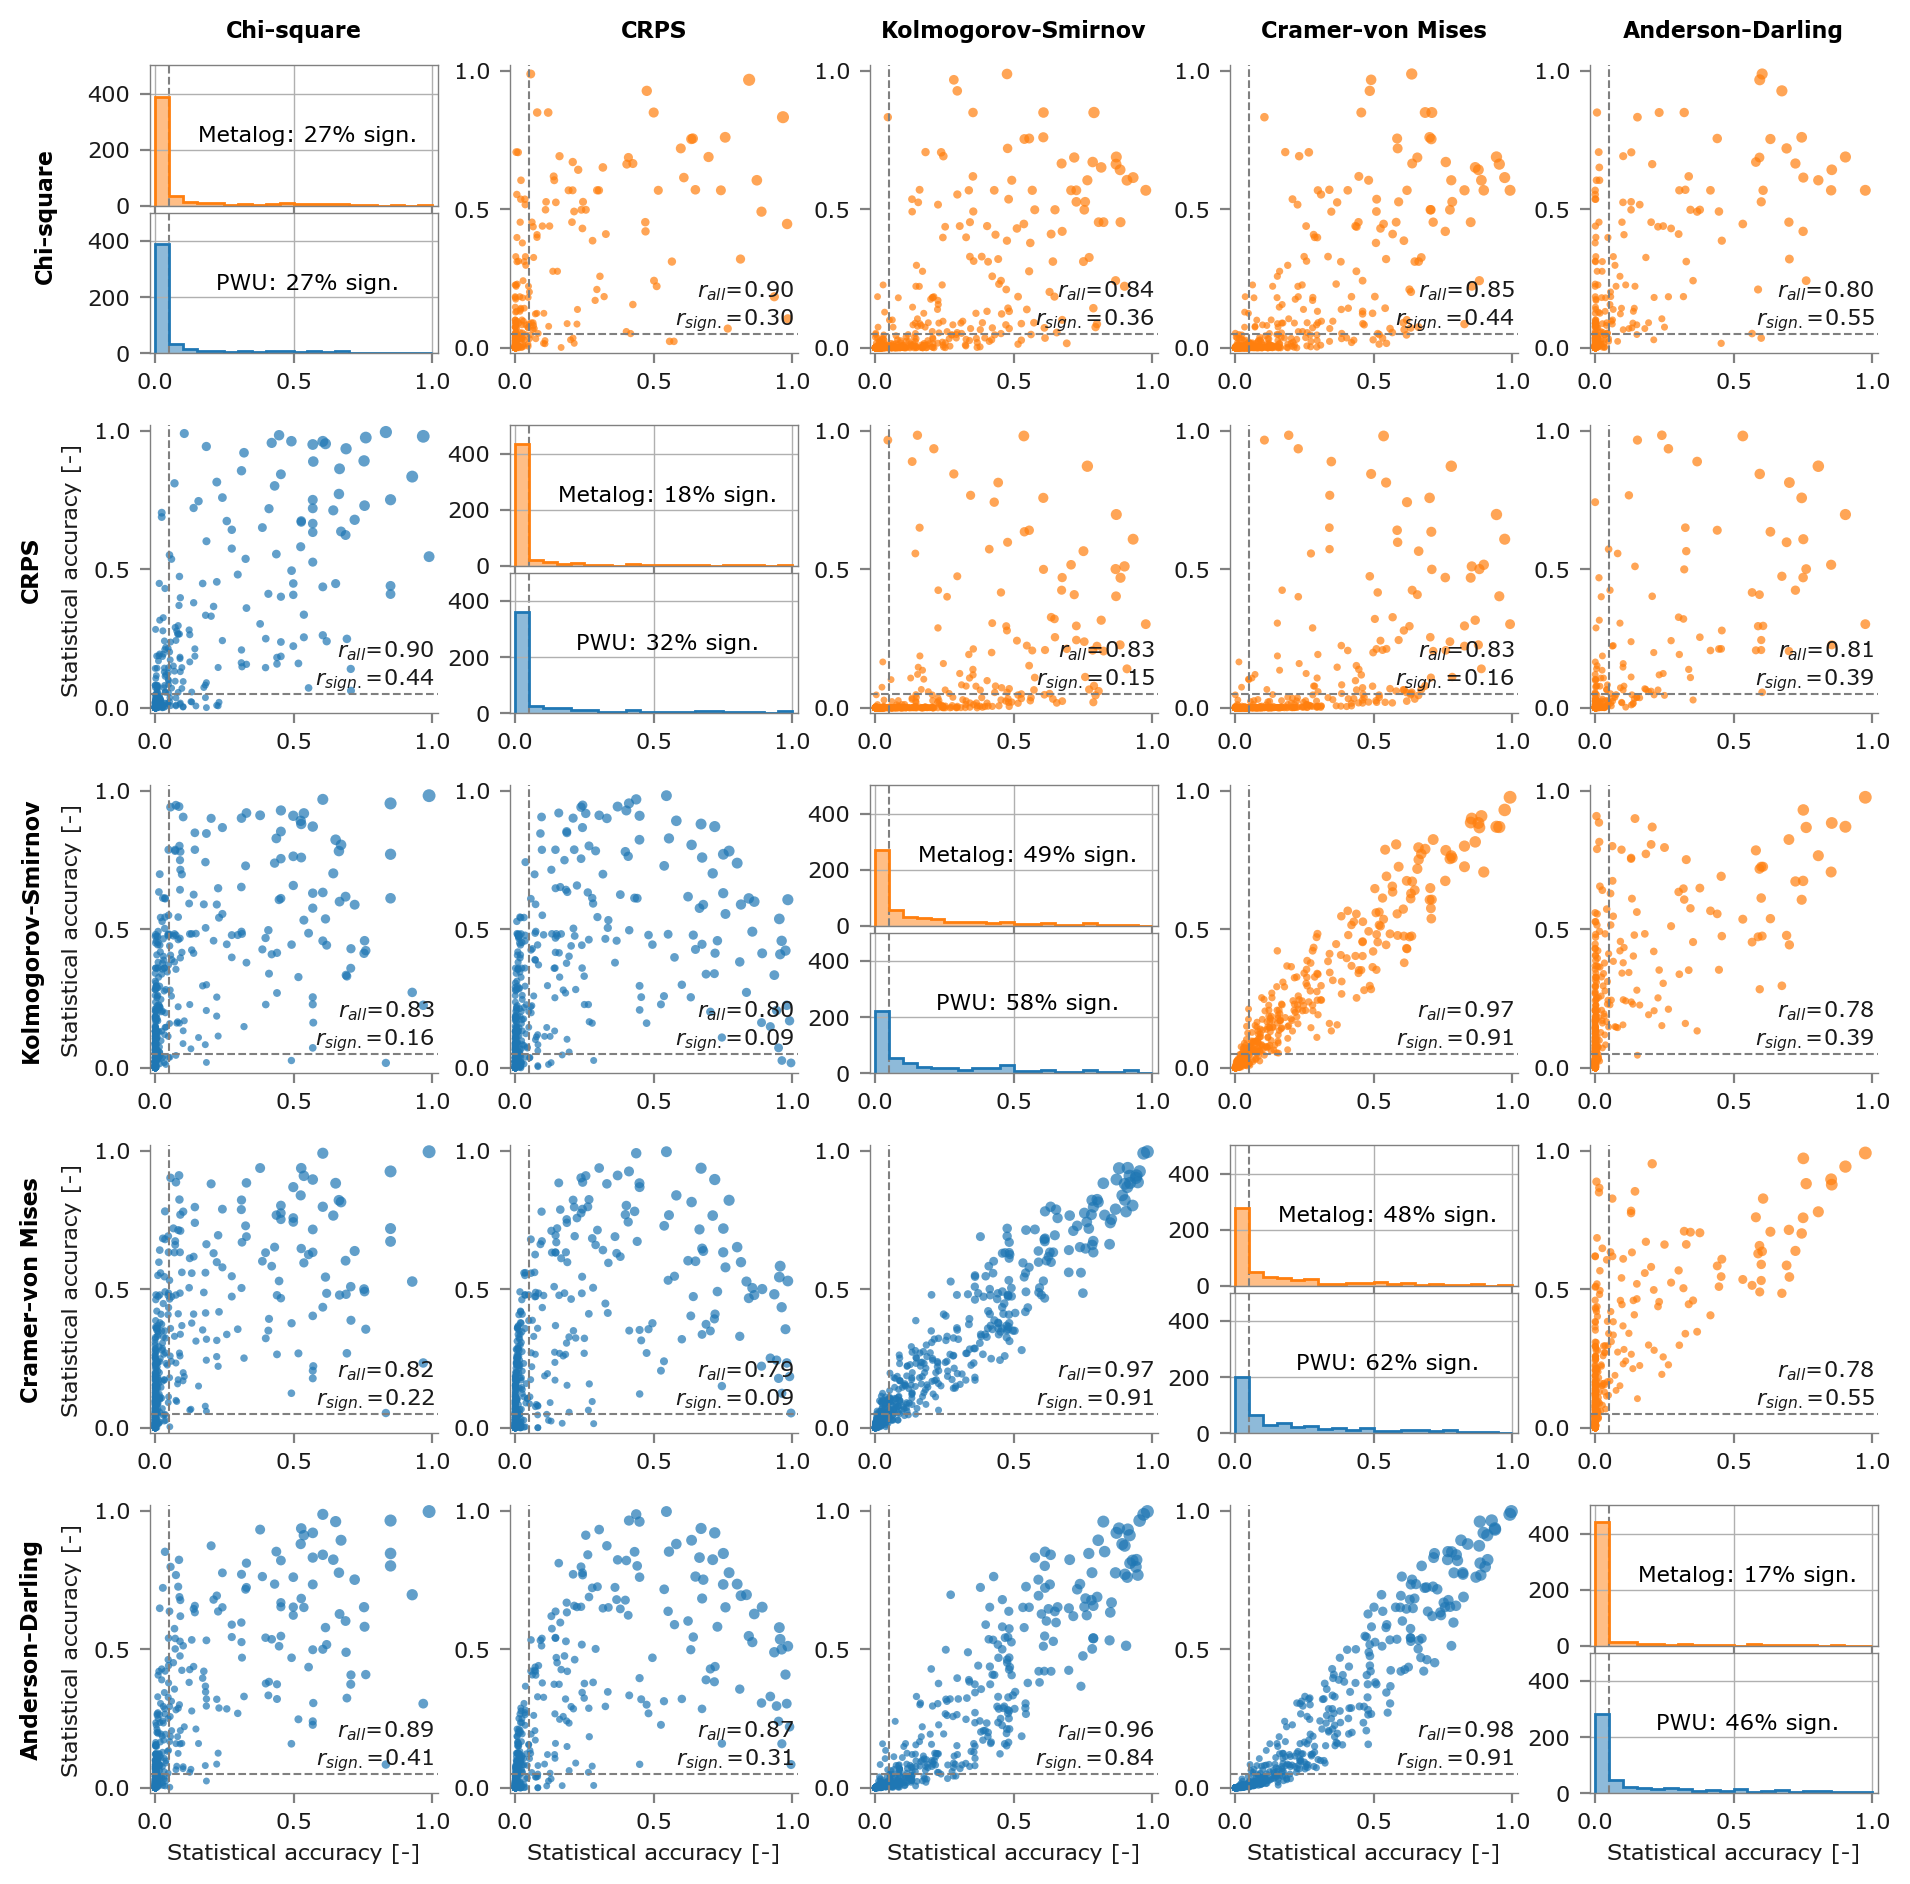

In [31]:
# variables = list(dfs.values())[0].columns.tolist()
n = len(variables)

from hkvpy import plotting

plotting.set_rcparams()
import itertools

fig = plt.figure(figsize=(9, 9))

w_off = 0.03
w = 0.16

h_off = 0.03
h = 0.16

ch_off = 0.03
ch = 0.16
cf = 2.05

f = 1/n

axs = []
for i in range(n):
    ipos = n - i
    rowax = []
    for j in range(n):
        if i == j:
            
            # continue
            # print(i*2, j)
            # print(i*2+1, j)
            ax = [fig.add_axes([j*f + w_off, ipos*f+ ch_off + (ch - ch/cf), w, ch/cf]), fig.add_axes([j*f + w_off, ipos*f+ ch_off, w, ch/cf])]
        else:
            ax = fig.add_axes([j*f + w_off, ipos*f + h_off, w, h])
        rowax.append(ax)
    axs.append(rowax)


cpwl = "0.1"
cml = ".45"

cpwl = "C0"
cml = "C1"


def corr_str(x, y):
    idx = (x > 0.05)  & (y >0.05)
    pearson_str = rf"$\rho$={np.corrcoef(x[idx], y[idx])[0, 1]:.2f}"
    spearman_str1 = r"$r_{all}$="+f"{spearmanr(x, y).correlation:.2f}"
    spearman_str2 = r"$r_{sign.}$="+f"{spearmanr(x[idx], y[idx]).correlation:.2f}"
    return spearman_str1 + "\n" + spearman_str2



hist_kwargs = dict(range=(0, 1), bins=20)
filled_kwargs = dict(alpha=0.5, cumulative=False, zorder=-5)
step_kwargs = dict(alpha=1.0, histtype="step", cumulative=False, lw=1)

for (varx, vary) in itertools.product(variables, variables):

    i = variables.index(vary)
    j = variables.index(varx)
    ax = axs[i][j]
    
    if i == j:
        # continue
        ax[0].set_xlim(-0.02, 1.02)
        ax[1].set_xlim(-0.02, 1.02)

        ax[0].set_xticks([])
        
        ax[0].hist(dfs["Metalog"][varx], color=cml, **hist_kwargs, **step_kwargs)
        ax[0].hist(dfs["Metalog"][varx], color=cml, **hist_kwargs, **filled_kwargs)
        
        ax[1].hist(dfs["PWL"][varx], color=cpwl, **hist_kwargs, **step_kwargs)
        ax[1].hist(dfs["PWL"][varx], color=cpwl, **hist_kwargs, **filled_kwargs)

        for x in ax:
            # x.hlines(np.array([0.2, 0.4, 0.6, 0.8, 1.0]) * len(dfs["Metalog"]), xmin=0, xmax=1, color=".5", lw=0.5, ls=":")
            x.axvline(0.05, lw=0.75, ls="--", c=".5", zorder=-2)
            x.grid()
            x.set_ylim(0, 500)
            x.set_yticks([0, 200, 400])
            x.set(xticks=[0, 0.5, 1.0], xticklabels=[0.0, 0.5, 1.0] if x is ax[1] else ['', '', ''])
            
            # sns.utils.despine(ax=x)

        ninsign = (dfs["Metalog"][varx] < 0.05).sum()
        fsign = (dfs["Metalog"][varx] >= 0.05).sum() / len(dfs["Metalog"][varx])
        # ax[0].axhline(ninsign, lw=0.75, ls="--", c=".5", zorder=-2)
        ax[0].text(x=0.55, y=250, s=f'Metalog: {fsign*100:.0f}% sign.', ha='center', va='center')

        ninsign = (dfs["PWL"][varx] < 0.05).sum()
        fsign = (dfs["PWL"][varx] >= 0.05).sum() / len(dfs["PWL"][varx])
        # ax[1].axhline(ninsign, lw=0.75, ls="--", c=".5", zorder=-2)
        ax[1].text(x=0.55, y=250, s=f'PWU: {fsign*100:.0f}% sign.', ha='center', va='center')

        

    else:
        ax.set_aspect(1.0)
        sns.utils.despine(ax=ax)
        ax.set_xlim(-0.02, 1.02)
        ax.set_ylim(-0.02, 1.02)
        ax.axhline(0.05, lw=0.75, ls="--", c=".5")
        ax.axvline(0.05, lw=0.75, ls="--", c=".5")
        ax.set(xticks=[0, 0.5, 1.0], yticks=[0, 0.5, 1.0])#, xticklabels=['0', '½', '1'], yticklabels=['0', '½', '1'])

    if i > j:
        x, y = dfs["PWL"][varx], dfs["PWL"][vary]
        # nq = np.array([len(quantiles[case]) for case in dfs["PWL"].index.get_level_values(0)])
        ax.scatter(x, y, s=6 + (x + y) ** 2 * 4, lw=0, alpha=0.7, color=cpwl, rasterized=True)
        ax.annotate(corr_str(x, y), (0.99, 0.07), ha="right", va="bottom", xycoords="axes fraction", color='0.1')

    if i < j:
        x, y = dfs["Metalog"][varx], dfs["Metalog"][vary]
        ax.scatter(x, y, s=6 + (x + y) ** 2 * 4, lw=0, alpha=0.7, color=cml, rasterized=True)
        ax.annotate(corr_str(x, y), (0.99, 0.07), ha="right", va="bottom", xycoords="axes fraction", color='0.1')

    if i == n - 1:
        if isinstance(ax, list):
            ax[-1].set_xlabel('Statistical accuracy [-]')
        else:
            ax.set_xlabel('Statistical accuracy [-]')

    if j == 0 and not isinstance(ax, list):
        ax.set_ylabel('Statistical accuracy [-]')

for i, ax in enumerate([x[0] for x in axs]):
    if isinstance(ax, (list, tuple)):
        ax = ax[1]
    ax.annotate(
        variables[i],
        xy=(0, 0.5),
        xytext=(-ax.yaxis.labelpad - 3, 0),
        xycoords=ax.yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center" if i > 0 else 'bottom',
        rotation=90,
        fontsize=8,
        fontweight='bold'
    )

for i, ax in enumerate(axs[0]):
    if isinstance(ax, (list, tuple)):
        ax = ax[0]
    ax.annotate(
        variables[i],
        xy=(0.5, 1),
        xytext=(0, 10),
        xycoords="axes fraction",
        textcoords="offset points",
        ha="center",
        va="baseline",
        fontsize=8,
        fontweight='bold'
    )

    
# plotting.add_headers(fig, row_headers=variables, col_headers=variables, , fontsize=8, )
fig.subplots_adjust(top=0.8)
    
fig.savefig("./figures/expert_sa_scatters.pdf", dpi=220, bbox_inches="tight", pad_inches=0.01)

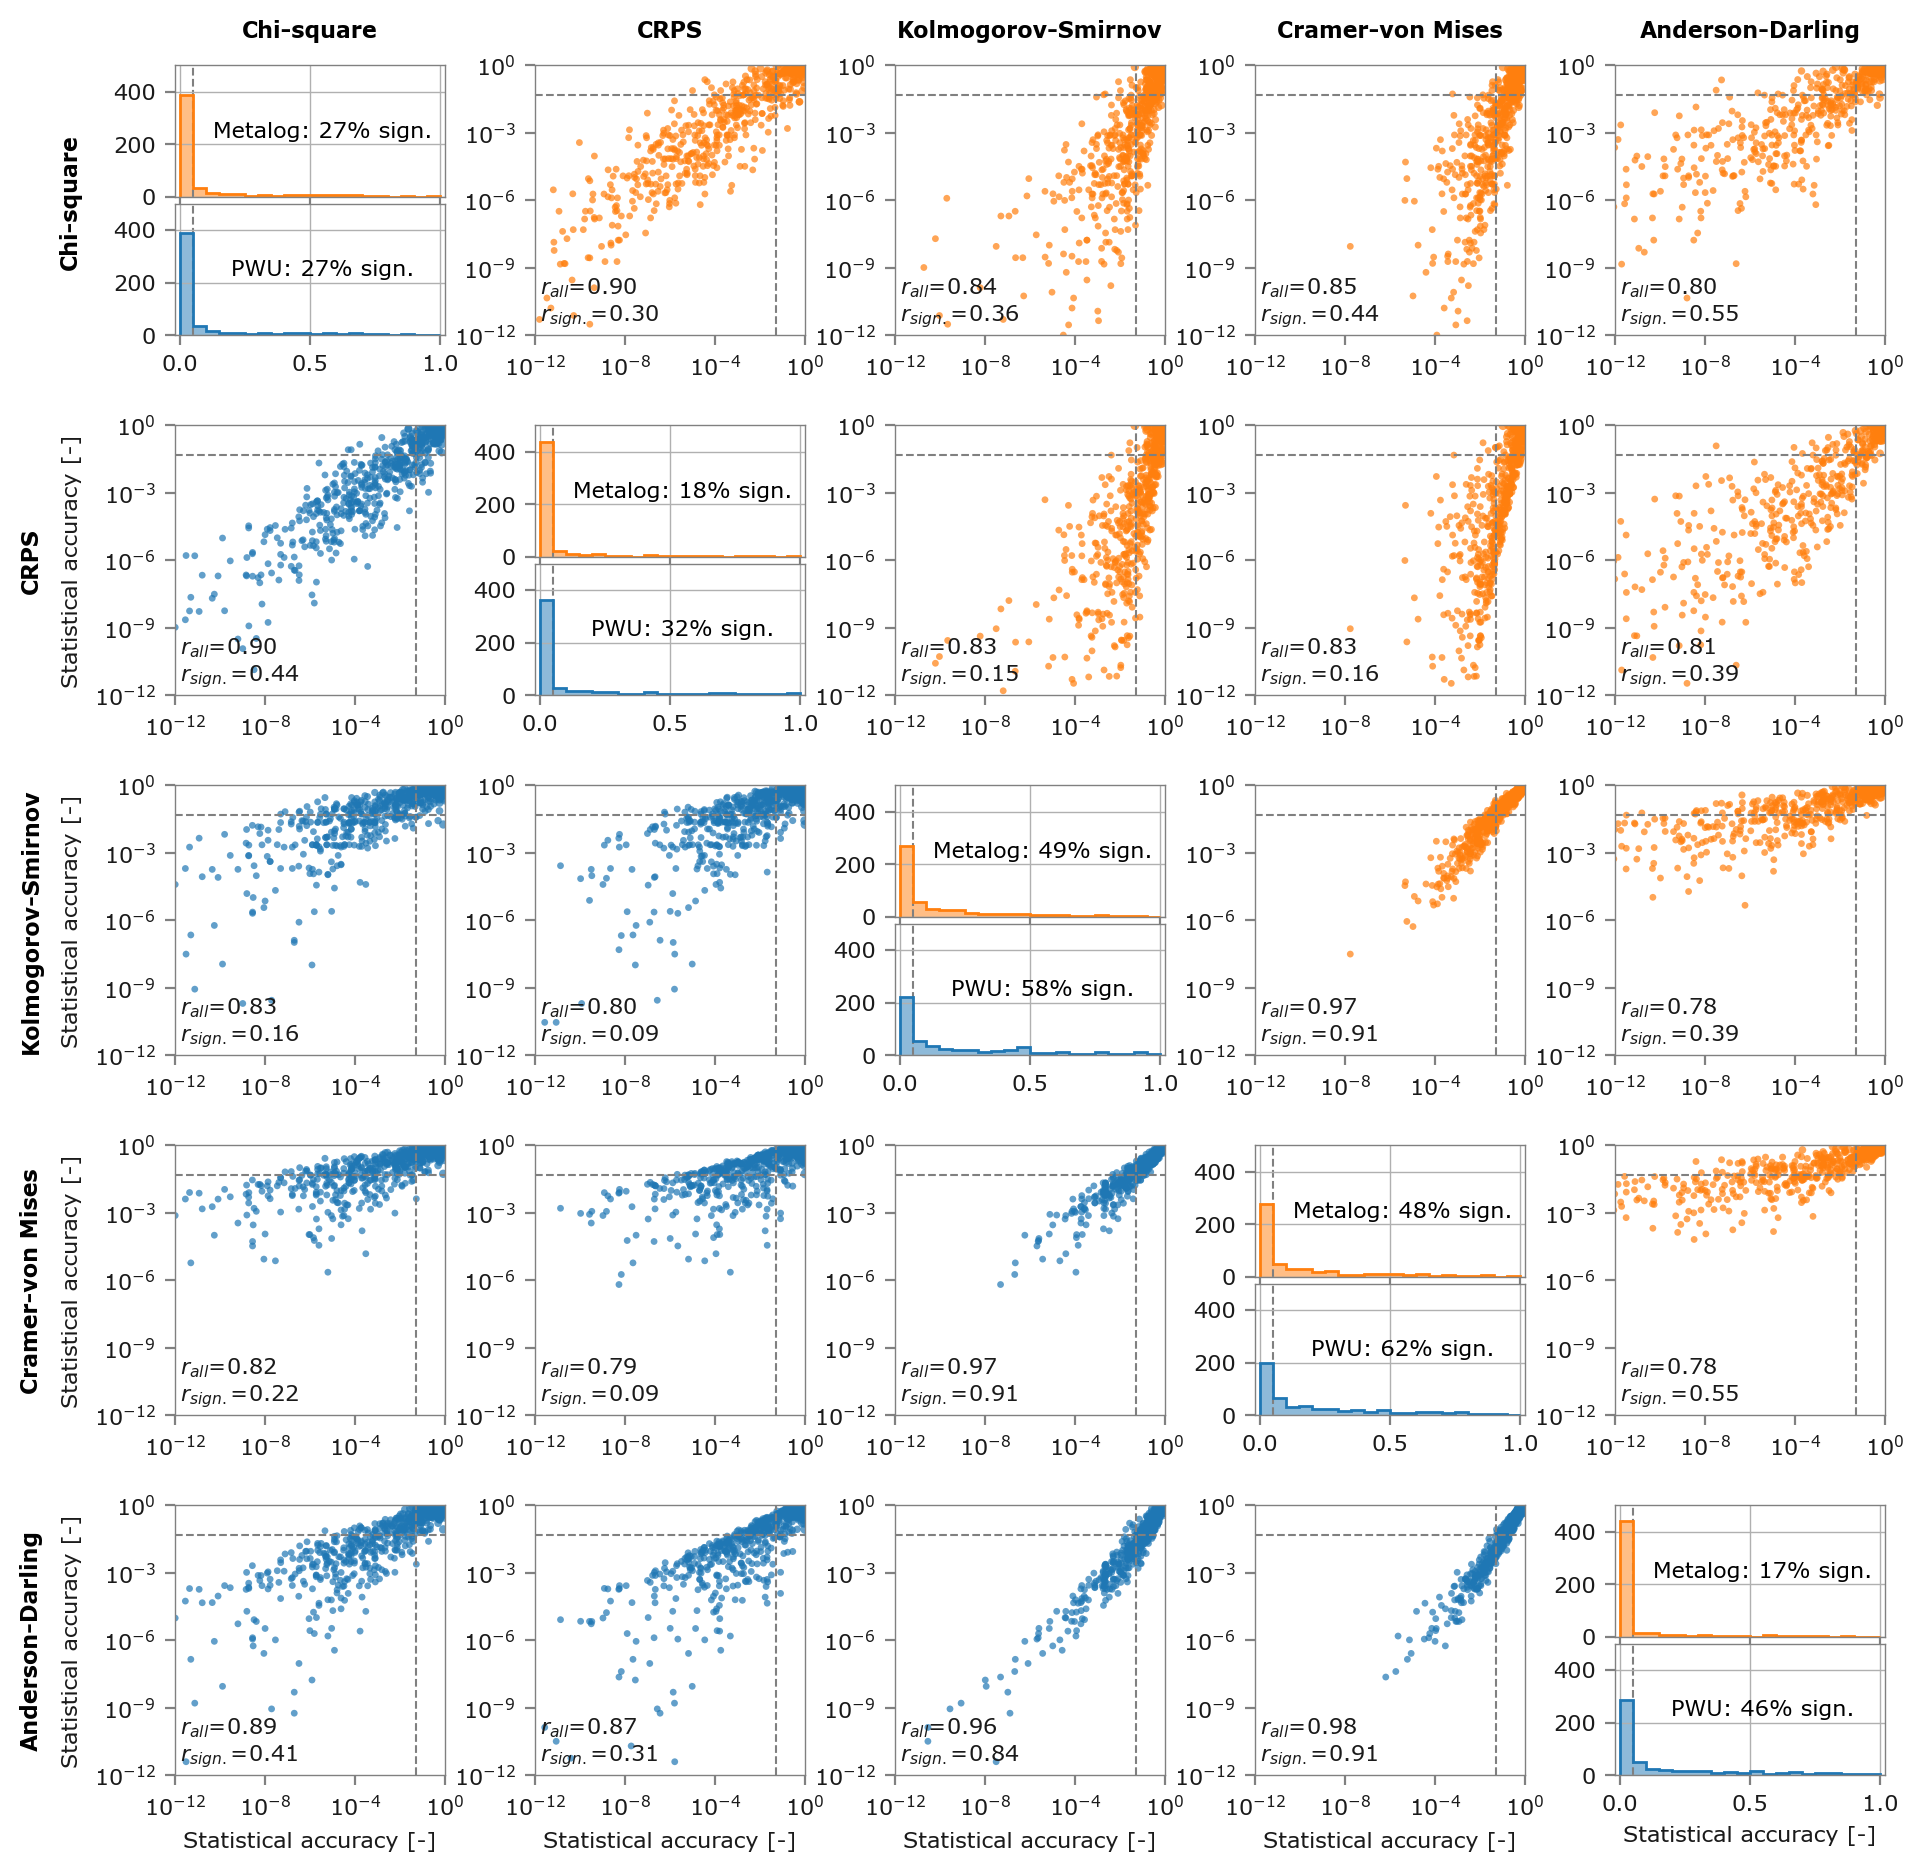

In [37]:
# variables = list(dfs.values())[0].columns.tolist()
n = len(variables)

from hkvpy import plotting

plotting.set_rcparams()
import itertools

fig = plt.figure(figsize=(9, 9))

w_off = 0.04
w = 0.15

h_off = 0.04
h = 0.15

ch_off = 0.04
ch = 0.15
cf = 2.05

f = 1/n

axs = []
for i in range(n):
    ipos = n - i
    rowax = []
    for j in range(n):
        if i == j:
            
            # continue
            # print(i*2, j)
            # print(i*2+1, j)
            ax = [fig.add_axes([j*f + w_off, ipos*f+ ch_off + (ch - ch/cf), w, ch/cf]), fig.add_axes([j*f + w_off, ipos*f+ ch_off, w, ch/cf])]
        else:
            ax = fig.add_axes([j*f + w_off, ipos*f + h_off, w, h])
        rowax.append(ax)
    axs.append(rowax)


cpwl = "0.1"
cml = ".45"

cpwl = "C0"
cml = "C1"


hist_kwargs = dict(range=(0, 1), bins=20)
filled_kwargs = dict(alpha=0.5, cumulative=False, zorder=-5)
step_kwargs = dict(alpha=1.0, histtype="step", cumulative=False, lw=1)

for (varx, vary) in itertools.product(variables, variables):

    i = variables.index(vary)
    j = variables.index(varx)
    ax = axs[i][j]
    
    if i == j:
        # continue
        ax[0].set_xlim(-0.02, 1.02)
        ax[1].set_xlim(-0.02, 1.02)

        ax[0].set_xticks([])
        
        ax[0].hist(dfs["Metalog"][varx], color=cml, **hist_kwargs, **step_kwargs)
        ax[0].hist(dfs["Metalog"][varx], color=cml, **hist_kwargs, **filled_kwargs)
        
        ax[1].hist(dfs["PWL"][varx], color=cpwl, **hist_kwargs, **step_kwargs)
        ax[1].hist(dfs["PWL"][varx], color=cpwl, **hist_kwargs, **filled_kwargs)

        for x in ax:
            # x.hlines(np.array([0.2, 0.4, 0.6, 0.8, 1.0]) * len(dfs["Metalog"]), xmin=0, xmax=1, color=".5", lw=0.5, ls=":")
            x.axvline(0.05, lw=0.75, ls="--", c=".5", zorder=-2)
            x.grid()
            x.set_ylim(0, 500)
            x.set_yticks([0, 200, 400])
            x.set(xticks=[0, 0.5, 1.0], xticklabels=[0.0, 0.5, 1.0] if x is ax[1] else ['', '', ''])
            
            # sns.utils.despine(ax=x)

        ninsign = (dfs["Metalog"][varx] < 0.05).sum()
        fsign = (dfs["Metalog"][varx] >= 0.05).sum() / len(dfs["Metalog"][varx])
        # ax[0].axhline(ninsign, lw=0.75, ls="--", c=".5", zorder=-2)
        ax[0].text(x=0.55, y=250, s=f'Metalog: {fsign*100:.0f}% sign.', ha='center', va='center')

        ninsign = (dfs["PWL"][varx] < 0.05).sum()
        fsign = (dfs["PWL"][varx] >= 0.05).sum() / len(dfs["PWL"][varx])
        # ax[1].axhline(ninsign, lw=0.75, ls="--", c=".5", zorder=-2)
        ax[1].text(x=0.55, y=250, s=f'PWU: {fsign*100:.0f}% sign.', ha='center', va='center')

        

    else:
        ax.set_aspect(1.0)
        # sns.utils.despine(ax=ax)
        ax.axhline(0.05, lw=0.75, ls="--", c=".5")
        ax.axvline(0.05, lw=0.75, ls="--", c=".5")
        ax.set(xticks=[0, 0.5, 1.0], yticks=[0, 0.5, 1.0], xscale='log', yscale='log')#, xticklabels=['0', '½', '1'], yticklabels=['0', '½', '1'])
        ax.set_xlim(1e-12, 1e0)
        ax.set_ylim(1e-12, 1e0)

    if i > j:
        x, y = dfs["PWL"][varx], dfs["PWL"][vary]
        ax.scatter(x, y, s=6 + (x + y) ** 2 * 4, lw=0, alpha=0.7, color=cpwl, rasterized=True)
        ax.annotate(corr_str(x, y), (0.02, 0.02), ha="left", va="bottom", xycoords="axes fraction", color='0.1')

    if i < j:
        x, y = dfs["Metalog"][varx], dfs["Metalog"][vary]
        ax.scatter(x, y, s=6 + (x + y) ** 2 * 4, lw=0, alpha=0.7, color=cml, rasterized=True)
        ax.annotate(corr_str(x, y), (0.02, 0.02), ha="left", va="bottom", xycoords="axes fraction", color='0.1')

    if i == n - 1:
        if isinstance(ax, list):
            ax[-1].set_xlabel('Statistical accuracy [-]')
        else:
            ax.set_xlabel('Statistical accuracy [-]')

    if j == 0 and not isinstance(ax, list):
        ax.set_ylabel('Statistical accuracy [-]')

for i, ax in enumerate([x[0] for x in axs]):
    if isinstance(ax, (list, tuple)):
        ax = ax[1]
    ax.annotate(
        variables[i],
        xy=(0, 0.5),
        xytext=(-ax.yaxis.labelpad - 3, 0),
        xycoords=ax.yaxis.label,
        textcoords="offset points",
        ha="right",
        va="center" if i > 0 else 'bottom',
        rotation=90,
        fontsize=8,
        fontweight='bold'
    )

for i, ax in enumerate(axs[0]):
    if isinstance(ax, (list, tuple)):
        ax = ax[0]
    ax.annotate(
        variables[i],
        xy=(0.5, 1),
        xytext=(0, 10),
        xycoords="axes fraction",
        textcoords="offset points",
        ha="center",
        va="baseline",
        fontsize=8,
        fontweight='bold'
    )

    
# plotting.add_headers(fig, row_headers=variables, col_headers=variables, , fontsize=8, )
fig.subplots_adjust(top=0.8)
    
fig.savefig("./figures/expert_sa_scatters_log.pdf", dpi=220, bbox_inches="tight", pad_inches=0.01)

In [24]:
df = dfs['Metalog'].corr(method='spearman').copy()
# dfs['Metalog'].corr(method='pearson')
for i, j in zip(*np.tril_indices(3)):
    df.iat[i, j] = dfs['PWL'].corr(method='spearman').iat[i, j]
df

,Chi-square,CRPS,Kolmogorov-Smirnov,Cramer-von Mises,Anderson-Darling
Chi-square,1.000000,0.902373,0.842051,0.848181,0.804258
CRPS,0.900440,1.000000,0.826710,0.828015,0.812433
Kolmogorov-Smirnov,0.832634,0.797888,1.000000,0.969768,0.783594
Cramer-von Mises,0.848181,0.828015,0.969768,1.000000,0.784784
Anderson-Darling,0.804258,0.812433,0.783594,0.784784,1.000000


In [25]:
method = 'spearman'
from IPython.display import display
display(dfs['Metalog'].corr(method=method))
display(dfs['PWL'].corr(method=method))

,Chi-square,CRPS,Kolmogorov-Smirnov,Cramer-von Mises,Anderson-Darling
Chi-square,1.000000,0.902373,0.842051,0.848181,0.804258
CRPS,0.902373,1.000000,0.826710,0.828015,0.812433
Kolmogorov-Smirnov,0.842051,0.826710,1.000000,0.969768,0.783594
Cramer-von Mises,0.848181,0.828015,0.969768,1.000000,0.784784
Anderson-Darling,0.804258,0.812433,0.783594,0.784784,1.000000


,Chi-square,CRPS,Kolmogorov-Smirnov,Cramer-von Mises,Anderson-Darling
Chi-square,1.000000,0.900440,0.832634,0.819565,0.888492
CRPS,0.900440,1.000000,0.797888,0.789835,0.867338
Kolmogorov-Smirnov,0.832634,0.797888,1.000000,0.965516,0.959933
Cramer-von Mises,0.819565,0.789835,0.965516,1.000000,0.979734
Anderson-Darling,0.888492,0.867338,0.959933,0.979734,1.000000


In [26]:
method = 'spearman'
dist = 'Metalog'
from IPython.display import display
idx = dfs['Metalog']
display(dfs['Metalog'].corr(method=method))
display(dfs['PWL'].corr(method=method))

,Chi-square,CRPS,Kolmogorov-Smirnov,Cramer-von Mises,Anderson-Darling
Chi-square,1.000000,0.902373,0.842051,0.848181,0.804258
CRPS,0.902373,1.000000,0.826710,0.828015,0.812433
Kolmogorov-Smirnov,0.842051,0.826710,1.000000,0.969768,0.783594
Cramer-von Mises,0.848181,0.828015,0.969768,1.000000,0.784784
Anderson-Darling,0.804258,0.812433,0.783594,0.784784,1.000000


,Chi-square,CRPS,Kolmogorov-Smirnov,Cramer-von Mises,Anderson-Darling
Chi-square,1.000000,0.900440,0.832634,0.819565,0.888492
CRPS,0.900440,1.000000,0.797888,0.789835,0.867338
Kolmogorov-Smirnov,0.832634,0.797888,1.000000,0.965516,0.959933
Cramer-von Mises,0.819565,0.789835,0.965516,1.000000,0.979734
Anderson-Darling,0.888492,0.867338,0.959933,0.979734,1.000000


In [27]:
corr = np.zeros((4, 4))

df = dfs['PWL']

method = 'spearman'

for (varx, vary) in itertools.product(variables, variables):

    i = variables.index(vary)
    j = variables.index(varx)
    
    if i == j:
        continue

    idx = (df[[varx, vary]] > 0.05).all(axis=1)
    if i > j:
        corr[i, j] = df.loc[idx.to_numpy(), [varx, vary]].corr(method=method).iat[0, 1]
    if j > i:
        corr[i, j] = df.loc[:, [varx, vary]].corr(method=method).iat[0, 1]
        
        
corr.round(3)

IndexError: index 4 is out of bounds for axis 0 with size 4